In [1]:
import numpy as np
import sklearn as sk
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from scipy import stats
import scipy.io as sio
import sys

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# Load
SAT_4 = sio.loadmat('flatten_SAT_4.mat')
train_x = SAT_4['train_x']
train_y = SAT_4['train_y']
index_mask = np.arange(train_x.shape[0])

# Input parameters
width = 28
height = 28
band = 4

input_size = width*height*band
class_output = 4

# Hyper parameters
conv_out = [0, 64, 256, 512]
            #   2048, 1024
layer_out = [0, 1024, 512]
last_conv_flatten = 4*4*conv_out[-1]

keep_rate = 1.0

batch_size = 64 # <- tuning
learning_rate = 9e-6
iteration = 50000

# Initialization:
# weight:
uni = True # Xavier (uniform / normal)
# bias: norm - mean=0, std=0.2  /// Xavier /// 0

# Normalize Parameters
Norm_Parameters = sio.loadmat("Feature_Norm.mat")
mu = Norm_Parameters["mu"];
sigma = Norm_Parameters["sigma"]

$a_i$ is the raw number (int)

$\mu = \frac 1 n \sum_{i=1}^n \frac {a_i} {\text{Max}} = \frac 1 {\text{Max}}(\frac 1 n \sum_{i=1}^n a_i)$

$\sigma = \sqrt{\frac 1 n \sum_{i=1}^n (\frac{a_i}{\text{Max}}-\mu)^2 } = \frac 1 {\text{Max}} \sqrt{\frac 1 n \sum_{i=1}^n(a_i-\mu*\text{Max})^2 } $

$\displaystyle \frac {\frac A {\text{Max}} - mu} {\sigma} = \frac {A-\mu *\text{Max}}{\sigma *\text{Max}}$

In [3]:
def run_experiment (mu=mu, sigma=sigma, train_x=train_x, train_y=train_y,
                    width=width, height=height, band=band, class_output=class_output,
                    conv_out=conv_out, layer_out=layer_out, keep_rate=keep_rate,
                    uni=uni, learning_rate=learning_rate, batch_size=batch_size, iteration=iteration):

    print(conv_out, layer_out, keep_rate)
    
    last_conv_flatten = 4*4*conv_out[-1]
    
    x  = tf.placeholder(tf.float32, shape=[None, width, height, band])
    y_ = tf.placeholder(tf.float32, shape=[None, class_output])

    # Convolutional Layer 1
    Xavier_conv1 = np.sqrt(2/(3*3*band+conv_out[1]))
    # W_conv1 = tf.Variable(tf.truncated_normal([3, 3, 4, conv_out[1]], stddev=Xavier_conv1))
    # b_conv1 = tf.Variable(tf.truncated_normal([conv_out[1]], stddev=0.1))
    W_conv1 = tf.get_variable('W_conv1', shape = [3, 3, 4, conv_out[1]], initializer=tf.contrib.layers.xavier_initializer(uniform=uni))
    b_conv1 = tf.Variable(tf.zeros([conv_out[1]]))

    convolve1= tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1
    h_conv1 = tf.nn.relu(convolve1)
    conv1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Convolutional Layer 2
    Xavier_conv2 = np.sqrt(2/(3*3*conv_out[1]+conv_out[2]))
    # W_conv2 = tf.Variable(tf.truncated_normal([3, 3, conv_out[1], conv_out[2]], stddev=Xavier_conv2))
    # b_conv2 = tf.Variable(tf.truncated_normal([conv_out[2]], stddev=0.1))
    W_conv2 = tf.get_variable("W_conv2", shape = [3, 3, conv_out[1], conv_out[2]], initializer=tf.contrib.layers.xavier_initializer(uniform=uni))
    b_conv2 = tf.Variable(tf.zeros([conv_out[2]]))

    convolve2= tf.nn.conv2d(conv1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')+ b_conv2
    h_conv2 = tf.nn.relu(convolve2)
    conv2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Convolutional Layer 3
    Xavier_conv3 = np.sqrt(2/(3*3*conv_out[2]+conv_out[3]))
    # W_conv3 = tf.Variable(tf.truncated_normal([3, 3, conv_out[2], conv_out[3]], stddev=Xavier_conv3))
    # b_conv3 = tf.Variable(tf.truncated_normal([conv_out[3]], stddev=0.1))
    W_conv3 = tf.get_variable("W_conv3", shape = [3, 3, conv_out[2], conv_out[3]], initializer=tf.contrib.layers.xavier_initializer(uniform=uni))
    b_conv3 = tf.Variable(tf.zeros([conv_out[3]]))

    convolve3= tf.nn.conv2d(conv2, W_conv3, strides = [1, 1, 1, 1], padding='SAME')+ b_conv3
    h_conv3 = tf.nn.relu(convolve3)
    conv3 = tf.nn.max_pool(h_conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

    # Flattening
    layer2_matrix = tf.reshape(conv3, [-1,last_conv_flatten])

    # Layer 1
    Xavier_layer1 = np.sqrt(2/(last_conv_flatten+layer_out[1]))
    # W_fc1 = tf.Variable(tf.truncated_normal([last_conv_flatten, layer_out[1]], stddev=Xavier_layer1))
    # b_fc1 = tf.Variable(tf.truncated_normal([layer_out[1]], stddev=0.1))
    W_fc1 = tf.get_variable('W_fc1', shape = [last_conv_flatten, layer_out[1]], initializer=tf.contrib.layers.xavier_initializer(uniform=uni))
    b_fc1 = tf.Variable(tf.zeros([layer_out[1]]))

    fcl=tf.matmul(layer2_matrix, W_fc1) + b_fc1
    h_fc1 = tf.nn.relu(fcl)

    # Drop out layer:
    keep_prob = tf.placeholder(tf.float32)
    layer_drop = tf.nn.dropout(h_fc1, keep_prob)

    # Layer 2
    Xavier_layer2 = np.sqrt(2/(layer_out[1]+layer_out[2]))
    # W_fc2 = tf.Variable(tf.truncated_normal([layer_out[1], layer_out[2]], stddev=Xavier_layer2)) # Xavier std = 0.044
    # b_fc2 = tf.Variable(tf.truncated_normal([layer_out[2]], stddev=0.1))
    W_fc2 = tf.get_variable('W_fc2', shape = [layer_out[1], layer_out[2]], initializer=tf.contrib.layers.xavier_initializer(uniform=uni))
    b_fc2 = tf.Variable(tf.zeros([layer_out[2]]))

    fc2=tf.matmul(layer_drop, W_fc2) + b_fc2
    h_fc2 = tf.nn.relu(fc2) # ReLU activation

    # Output Layer (Softmax):
    Xavier_out = np.sqrt(2/(layer_out[2]+class_output))
    W_fc3 = tf.get_variable('W_fc3', shape = [layer_out[2], class_output], initializer=tf.contrib.layers.xavier_initializer(uniform=uni))
    b_fc3 = tf.Variable(tf.zeros([class_output]))
    # W_fc3 = tf.Variable(tf.truncated_normal([layer_out[2], class_output], stddev=Xavier_out)) # Xavier std = 0.0625
    # b_fc3 = tf.Variable(tf.truncated_normal([class_output], stddev=0.1))

    fc=tf.matmul(h_fc2, W_fc3) + b_fc3

    y_CNN= tf.nn.softmax(fc)

    # Cost function & optimizer:
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * (y_CNN), reduction_indices=[1]))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

    correct_prediction = tf.equal(tf.argmax(y_CNN,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    # print(Xavier_conv1, Xavier_conv2, Xavier_conv3, Xavier_layer1, Xavier_layer2, Xavier_out)

    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())

    print(len(train_x)/batch_size)
    batch_num = int(len(train_x)/batch_size)

    print("start")
    learning_curve = []
    for i in range(iteration):
        start = (i%batch_num) * batch_size
        end = start + batch_size
        train_index = index_mask[start:end]

        batch = [((train_x[train_index]-mu)/sigma).reshape(-1,width,height,band), train_y[train_index]]
        if i%1000 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
            learning_curve.append(train_accuracy)
            
        if i*batch_size % train_x.shape[0]:
            np.random.shuffle(index_mask)
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: keep_rate})
    print("finish")

    # Training Acc
    train_acc = []
    print(train_x.shape[0]/10)
    for i in range(int(train_x.shape[0]/10)):
        start = i*10
        end = start + 10
        batch = [((train_x[start:end]-mu)/sigma).reshape(-1,width,height,band), train_y[start:end]]

        train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
        train_acc.append(train_accuracy)
    train_acc = sum(train_acc)/len(train_acc)
    print("Training Acc = ", train_acc)

    # Test Acc
    test_x = SAT_4['test_x']
    test_y = SAT_4['test_y']

    test_acc = []
    print(test_x.shape[0]/10)

    for i in range(int(test_x.shape[0]/10)):
        start = i*10
        end = start+10
        test_acc.append(accuracy.eval(
                    feed_dict={x:((test_x[start:end]-mu)/sigma).reshape([-1,width,height,band]), 
                               y_:test_y[start:end], 
                               keep_prob:1.0}))

    test_acc = sum(test_acc)/len(test_acc)
    print("Test Acc = ", test_acc)

    # plot learning curve
    learning_curve = np.array(learning_curve)
    plt.figure(figsize=(20,5))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.plot(learning_curve)
    plt.axhline(0.8, color='r')
    plt.axhline(0.9, color='r')
    plt.axhline(1.0, color='r')
    plt.savefig(str(conv_out) + " " + str(layer_out) + "-" + str(train_acc) + ".png")
    plt.show()
    plt.clf()

    sess.close() #finish the session

1: [0, 64, 128, 256] [0, 128, 64] 0.5
6250.0
start
finish
40000.0
Training Acc =  0.788335008244
10000.0
Test Acc =  0.78878000837


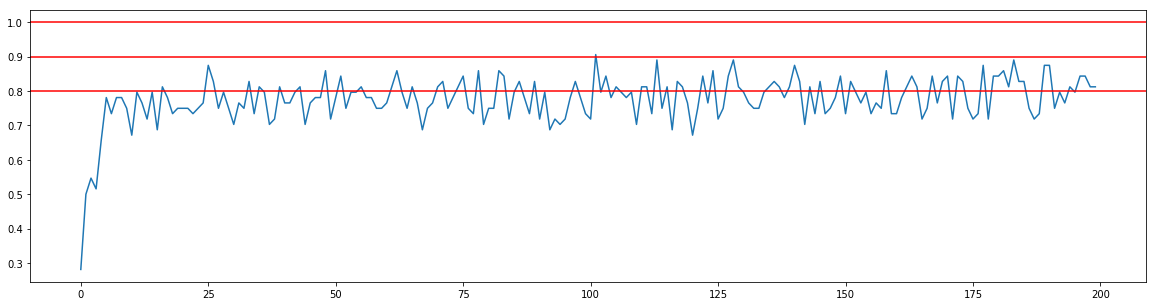

2: [0, 64, 128, 256] [0, 128, 64] 0.5
6250.0
start
finish
40000.0
Training Acc =  0.974084995538
10000.0
Test Acc =  0.973439995408


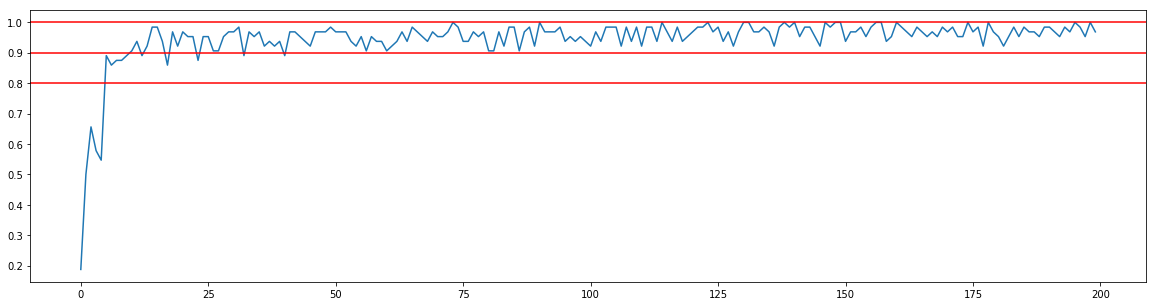

1: [0, 64, 128, 256] [0, 2048, 512] 0.5
6250.0
start
finish
40000.0
Training Acc =  0.787325008417
10000.0
Test Acc =  0.787270008519


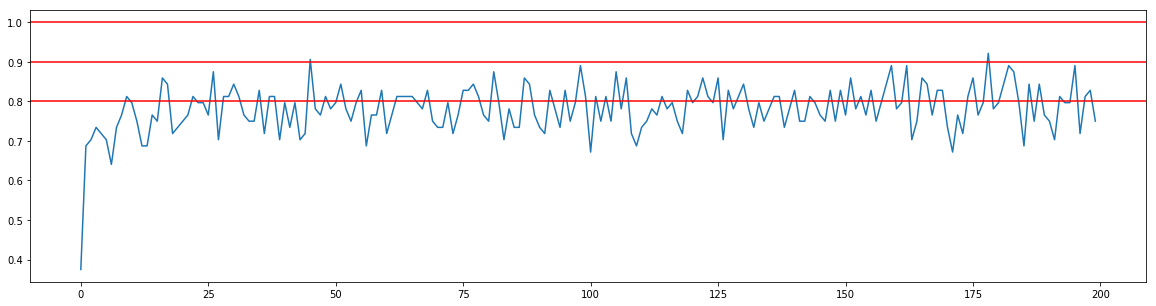

2: [0, 64, 128, 256] [0, 2048, 512] 0.5
6250.0
start
finish
40000.0
Training Acc =  0.790495008012
10000.0
Test Acc =  0.790770008141


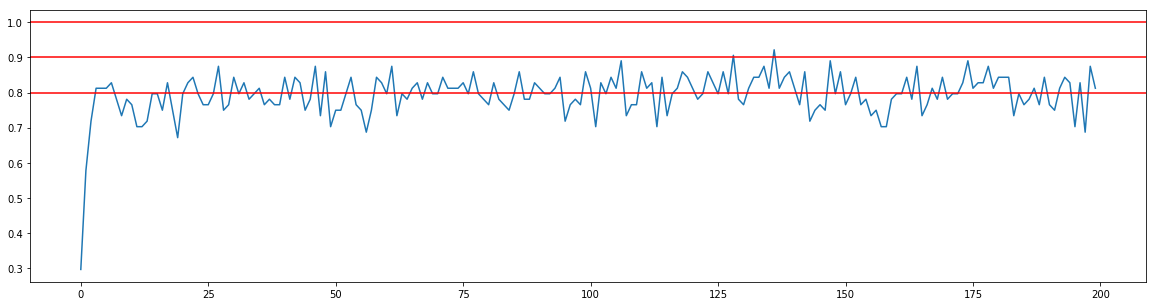

1  :
[0, 64, 256, 512] [0, 4096, 1024] 0.5
6250.0
start
finish
40000.0
Training Acc =  0.790160008037
10000.0
Test Acc =  0.790430008286


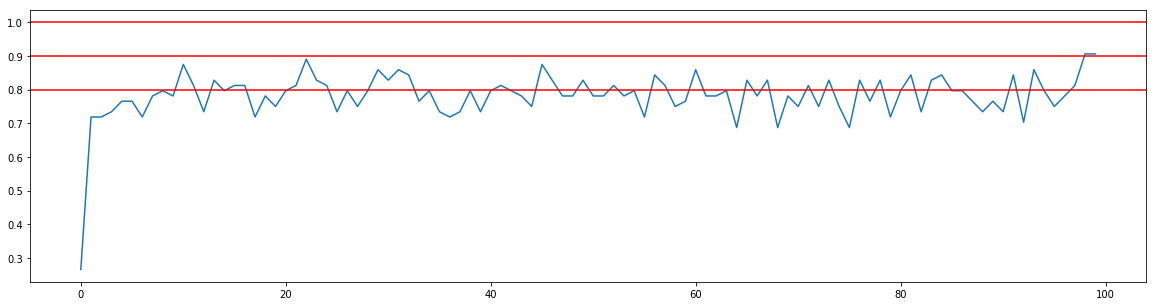

2  :
[0, 64, 256, 512] [0, 4096, 1024] 0.5
6250.0
start
finish
40000.0
Training Acc =  0.790857507956
10000.0
Test Acc =  0.791180008161


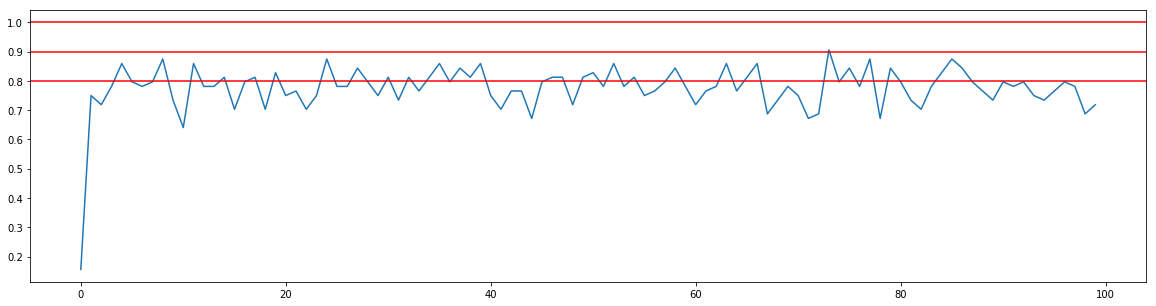

3  :
[0, 64, 256, 512] [0, 4096, 1024] 0.5
6250.0
start
finish
40000.0
Training Acc =  0.791025007957
10000.0
Test Acc =  0.791290008119


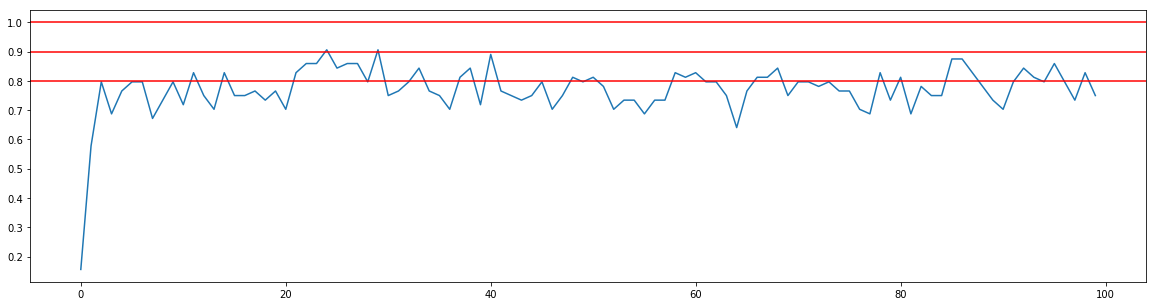

In [4]:
for layer in ([0, 128, 64], [0, 2048, 512], [0,1024,512]):
    for i in range(1,4):
        print(i, end=": ")
        run_experiment(conv_out=[0, 64, 128, 256], layer_out=layer, keep_rate=0.5, iteration=100000)
        tf.reset_default_graph()
    print("================================================================================================================================================")
    print("================================================================================================================================================")
    print("================================================================================================================================================")
    
for i in range(1,4):        
    print(i, " :")
    run_experiment(conv_out=[0, 64, 256, 512], layer_out=[0, 4096, 1024], keep_rate=0.5, iteration=100000)   
    tf.reset_default_graph()

# for i in range(1,4):        
#     print(i, " :")
#     run_experiment(conv_out=[0, 64, 256, 512], layer_out=[0, 4096, 1024], keep_rate=0.5, iteration=100000)   
#     tf.reset_default_graph()
    